In [1]:
#import modules
import numpy as np
import pandas as pd
import time
from keras import backend as K 
from keras.engine.training import Model
from keras.utils import to_categorical, plot_model
from keras.models import Sequential, load_model
from sklearn.preprocessing import MinMaxScaler
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dropout, Activation, Flatten
from keras.layers import LSTM, Dense, Input
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('./Sub0-RAW.csv')
df.head()

,Dates,Year,Month,Day,Hours,Precipitation,Temperature,Outflow
0,10/1/1980,1980,10,1,0:00:00,0.0,102.992,5.0
1,10/1/1980,1980,10,1,1:00:00,0.0,97.790,5.0
2,10/1/1980,1980,10,1,2:00:00,0.0,92.588,5.0
3,10/1/1980,1980,10,1,3:00:00,0.0,87.404,5.0
4,10/1/1980,1980,10,1,4:00:00,0.0,85.172,5.0


In [3]:
train_cols = ["Precipitation","Temperature","Outflow"]
label_cols = ["Outflow(t+1)"]

In [4]:
new_df = df.filter(train_cols, axis=1)

In [5]:
#Min Max scalr normalizing
xtrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
xtest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))

In [6]:
#function to shift the time_series data for getting labels
def lag_seq(df, n_seq):
    for i in range(n_seq):
        df['Outflow(t+%d)' %(i+1)] = new_df['Outflow'].shift(-(i+1))
    return df

#calling function to create lag dataframe
lag_df = lag_seq(new_df, 1)
lag_df.dropna(inplace=True)

#Splitting training and test data
df_train, df_test = train_test_split(lag_df, train_size=0.8, test_size=0.2, shuffle=False)
x_train = df_train.loc[:,train_cols].values
y_train = df_train.loc[:,label_cols].values
x_test = df_test.loc[:,train_cols].values
y_test = df_test.loc[:,label_cols].values    
   

In [7]:
# checking mse for train set that are greater than threshold
threshold = 250
timesteps = 18
train_values_above_thres = []
train_labels_above_theres = []

for i in range(timesteps, x_train.shape[0]):
    if (y_train[i] > threshold):
        train_values_above_thres.append(x_train[i-timesteps:i])
        train_labels_above_theres.append(y_train[i]) 
        
X_train_abv_thres = np.array(train_values_above_thres)
Y_train_abv_thres = np.array(train_labels_above_theres)

tsamples, ta, tb = X_train_abv_thres.shape
x_train_for_normalization = X_train_abv_thres.reshape((tsamples,ta*tb)) # since normalization requires 2d array
x_train_for_normalization.shape

X_Train_abv_thres = xtrain_min_max_scaler.fit_transform(x_train_for_normalization)
Y_Train_abv_thres = ytrain_min_max_scaler.fit_transform(Y_train_abv_thres)

X_Train_abv_thres = X_Train_abv_thres.reshape((tsamples, ta, tb))

In [8]:
# checking mse for test set that are greater than threshold
threshold = 250
timesteps = 18
test_values_above_thres = []
test_labels_above_theres = []

for i in range(timesteps, x_test.shape[0]):
    if (y_test[i] > threshold):
        test_values_above_thres.append(x_test[i-timesteps:i])
        test_labels_above_theres.append(y_test[i]) 
        
X_test_abv_thres = np.array(test_values_above_thres)
Y_test_abv_thres = np.array(test_labels_above_theres)

tsamples, ta, tb = X_test_abv_thres.shape
x_test_for_normalization = X_test_abv_thres.reshape((tsamples,ta*tb)) # since normalization requires 2d array
x_test_for_normalization.shape

X_Test_abv_thres = xtest_min_max_scaler.fit_transform(x_test_for_normalization)
Y_Test_abv_thres = ytest_min_max_scaler.fit_transform(Y_test_abv_thres)

X_Test_abv_thres = X_Test_abv_thres.reshape((tsamples, ta, tb))

In [9]:
X_Train_abv_thres.shape, X_Test_abv_thres.shape

((1678, 18, 3), (553, 18, 3))

In [10]:
Y_Train_abv_thres.shape, Y_Test_abv_thres.shape

((1678, 1), (553, 1))

In [11]:
Y_Test_abv_thres

array([[5.21270222e-02],
       [1.53385261e-01],
       [2.31875374e-01],
       [2.69622528e-01],
       [2.60635111e-01],
       [2.28879569e-01],
       [2.00119832e-01],
       [1.73157579e-01],
       [1.48591971e-01],
       [1.25823847e-01],
       [1.05452367e-01],
       [8.62792091e-02],
       [7.30976633e-02],
       [6.65068904e-02],
       [6.53085680e-02],
       [6.53085680e-02],
       [6.35110845e-02],
       [5.69203116e-02],
       [4.49370881e-02],
       [3.05572199e-02],
       [1.67765129e-02],
       [4.19412822e-03],
       [1.19832235e-02],
       [1.61773517e-02],
       [1.01857400e-02],
       [0.00000000e+00],
       [0.00000000e+00],
       [2.99580587e-03],
       [2.75614140e-02],
       [9.76632714e-02],
       [1.46794488e-01],
       [1.62372678e-01],
       [1.50988616e-01],
       [1.29418814e-01],
       [1.07849011e-01],
       [8.80766926e-02],
       [6.95026962e-02],
       [5.27261833e-02],
       [3.71479928e-02],
       [2.33672858e-02],


In [12]:
#Build Model
def make_model(X_Train):
    input_layer = Input(shape=(X_Train_abv_thres.shape[1], X_Train_abv_thres.shape[2]))

    conv1 = Conv1D(filters=16, kernel_size=3, strides=1,
                    padding='same',activation='relu')(input_layer)
    conv2 = Conv1D(filters=32, kernel_size=3,strides = 1,
                          padding='same', activation='relu')(conv1)
    conv3 = Conv1D(filters=64, kernel_size=3,strides = 1,
                          padding='same', activation='relu')(conv2)

    flatten = Flatten()(conv3)

    dense1 = Dense(1152, activation='relu')(flatten)
    dense2 = Dense(576, activation='relu')(dense1)
    output_layer = Dense(1, activation='linear')(dense2)
    
    return Model(inputs=input_layer, outputs=output_layer)

In [13]:
mse_for_iter = []
train_loss_over_epoch = []
val_loss_over_epoch = []
predicted_y_values_unnors = []
models = []
def run_iteration(no_iter=20, epochs = 10):
    start_time = time.time()
    for iteration in range(no_iter):
        print(f'Iteration: {iteration + 1}')
        K.clear_session()
        model = make_model(X_Train_abv_thres)
        #plot_model(model, show_shapes=True)
        model.compile(optimizer = 'adam', loss = 'mean_squared_error')
        history = model.fit(X_Train_abv_thres, Y_Train_abv_thres, epochs=epochs,
                       validation_data=(X_Test_abv_thres, Y_Test_abv_thres))
        train_loss_over_epoch.append(history.history['loss'])
        val_loss_over_epoch.append(history.history['val_loss'])
        predicted_y_values = model.predict(X_Test_abv_thres)
        predicted_y_values_unnor = ytrain_min_max_scaler.inverse_transform(predicted_y_values)
        mse_for_iter.append(mean_squared_error(predicted_y_values_unnor, Y_Test_abv_thres))
        predicted_y_values_unnors.append(predicted_y_values_unnor)
        models.append(model)
        
    end_time = time.time()
    print('--------------------------\n')
    print(f'Starting time: {start_time}')
    print(f'Completing time: {end_time}')
    print(f'It took {(start_time - end_time)/60} minutes to train the model for {no_iter} iterations')
    #return predicted unnormalized values for test set from last iteration 
    return predicted_y_values_unnor, model

predicted_y_values_unnor, model = run_iteration(20,10)

Iteration: 1
Epoch 1/10
53/53 [==============================] - 2s 32ms/step - loss: 0.0243 - val_loss: 0.0102
Epoch 2/10
53/53 [==============================] - 2s 30ms/step - loss: 0.0036 - val_loss: 0.0078
Epoch 3/10
53/53 [==============================] - 1s 24ms/step - loss: 0.0021 - val_loss: 0.0047
Epoch 4/10
53/53 [==============================] - 2s 33ms/step - loss: 0.0014 - val_loss: 0.0051
Epoch 5/10
53/53 [==============================] - 1s 26ms/step - loss: 9.3422e-04 - val_loss: 0.0045
Epoch 6/10
53/53 [==============================] - 2s 29ms/step - loss: 7.8008e-04 - val_loss: 0.0042
Epoch 7/10
53/53 [==============================] - 1s 25ms/step - loss: 7.0200e-04 - val_loss: 0.0037
Epoch 8/10
53/53 [==============================] - 1s 24ms/step - loss: 4.5220e-04 - val_loss: 0.0038
Epoch 9/10
53/53 [==============================] - 1s 18ms/step - loss: 5.7333e-04 - val_loss: 0.0031
Epoch 10/10
53/53 [==============================] - 1s 18ms/step - loss: 5.

Epoch 1/10
53/53 [==============================] - 2s 20ms/step - loss: 0.0353 - val_loss: 0.0100
Epoch 2/10
53/53 [==============================] - 1s 18ms/step - loss: 0.0034 - val_loss: 0.0062
Epoch 3/10
53/53 [==============================] - 1s 17ms/step - loss: 0.0019 - val_loss: 0.0048
Epoch 4/10
53/53 [==============================] - 1s 17ms/step - loss: 0.0015 - val_loss: 0.0036
Epoch 5/10
53/53 [==============================] - 1s 18ms/step - loss: 8.3031e-04 - val_loss: 0.0044
Epoch 6/10
53/53 [==============================] - 1s 17ms/step - loss: 8.8139e-04 - val_loss: 0.0046
Epoch 7/10
53/53 [==============================] - 1s 23ms/step - loss: 5.5980e-04 - val_loss: 0.0034
Epoch 8/10
53/53 [==============================] - 1s 21ms/step - loss: 5.2364e-04 - val_loss: 0.0034
Epoch 9/10
53/53 [==============================] - 1s 17ms/step - loss: 4.1808e-04 - val_loss: 0.0036
Epoch 10/10
53/53 [==============================] - 1s 18ms/step - loss: 4.4179e-04 - va

Iteration: 17
Epoch 1/10
53/53 [==============================] - 2s 21ms/step - loss: 0.0504 - val_loss: 0.0113
Epoch 2/10
53/53 [==============================] - 1s 18ms/step - loss: 0.0057 - val_loss: 0.0076
Epoch 3/10
53/53 [==============================] - 1s 17ms/step - loss: 0.0032 - val_loss: 0.0064
Epoch 4/10
53/53 [==============================] - 1s 17ms/step - loss: 0.0024 - val_loss: 0.0056
Epoch 5/10
53/53 [==============================] - 1s 18ms/step - loss: 0.0016 - val_loss: 0.0063
Epoch 6/10
53/53 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 0.0050
Epoch 7/10
53/53 [==============================] - 1s 20ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 8/10
53/53 [==============================] - 1s 22ms/step - loss: 9.2714e-04 - val_loss: 0.0039
Epoch 9/10
53/53 [==============================] - 1s 19ms/step - loss: 6.2067e-04 - val_loss: 0.0041
Epoch 10/10
53/53 [==============================] - 1s 21ms/step - loss: 5.5328e-04 - 

In [14]:
model.save("cnn_model1_three_features_extreme_cases.hdf5")

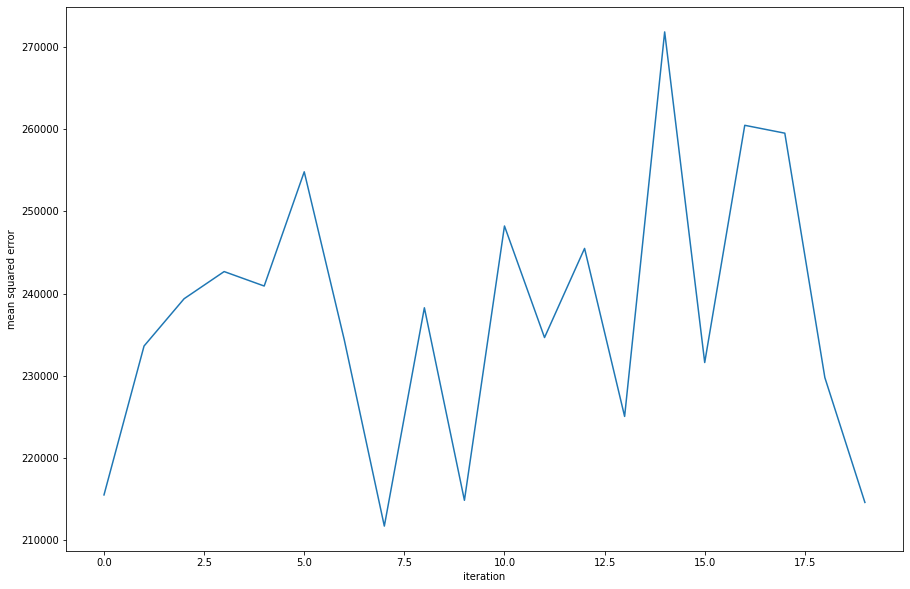

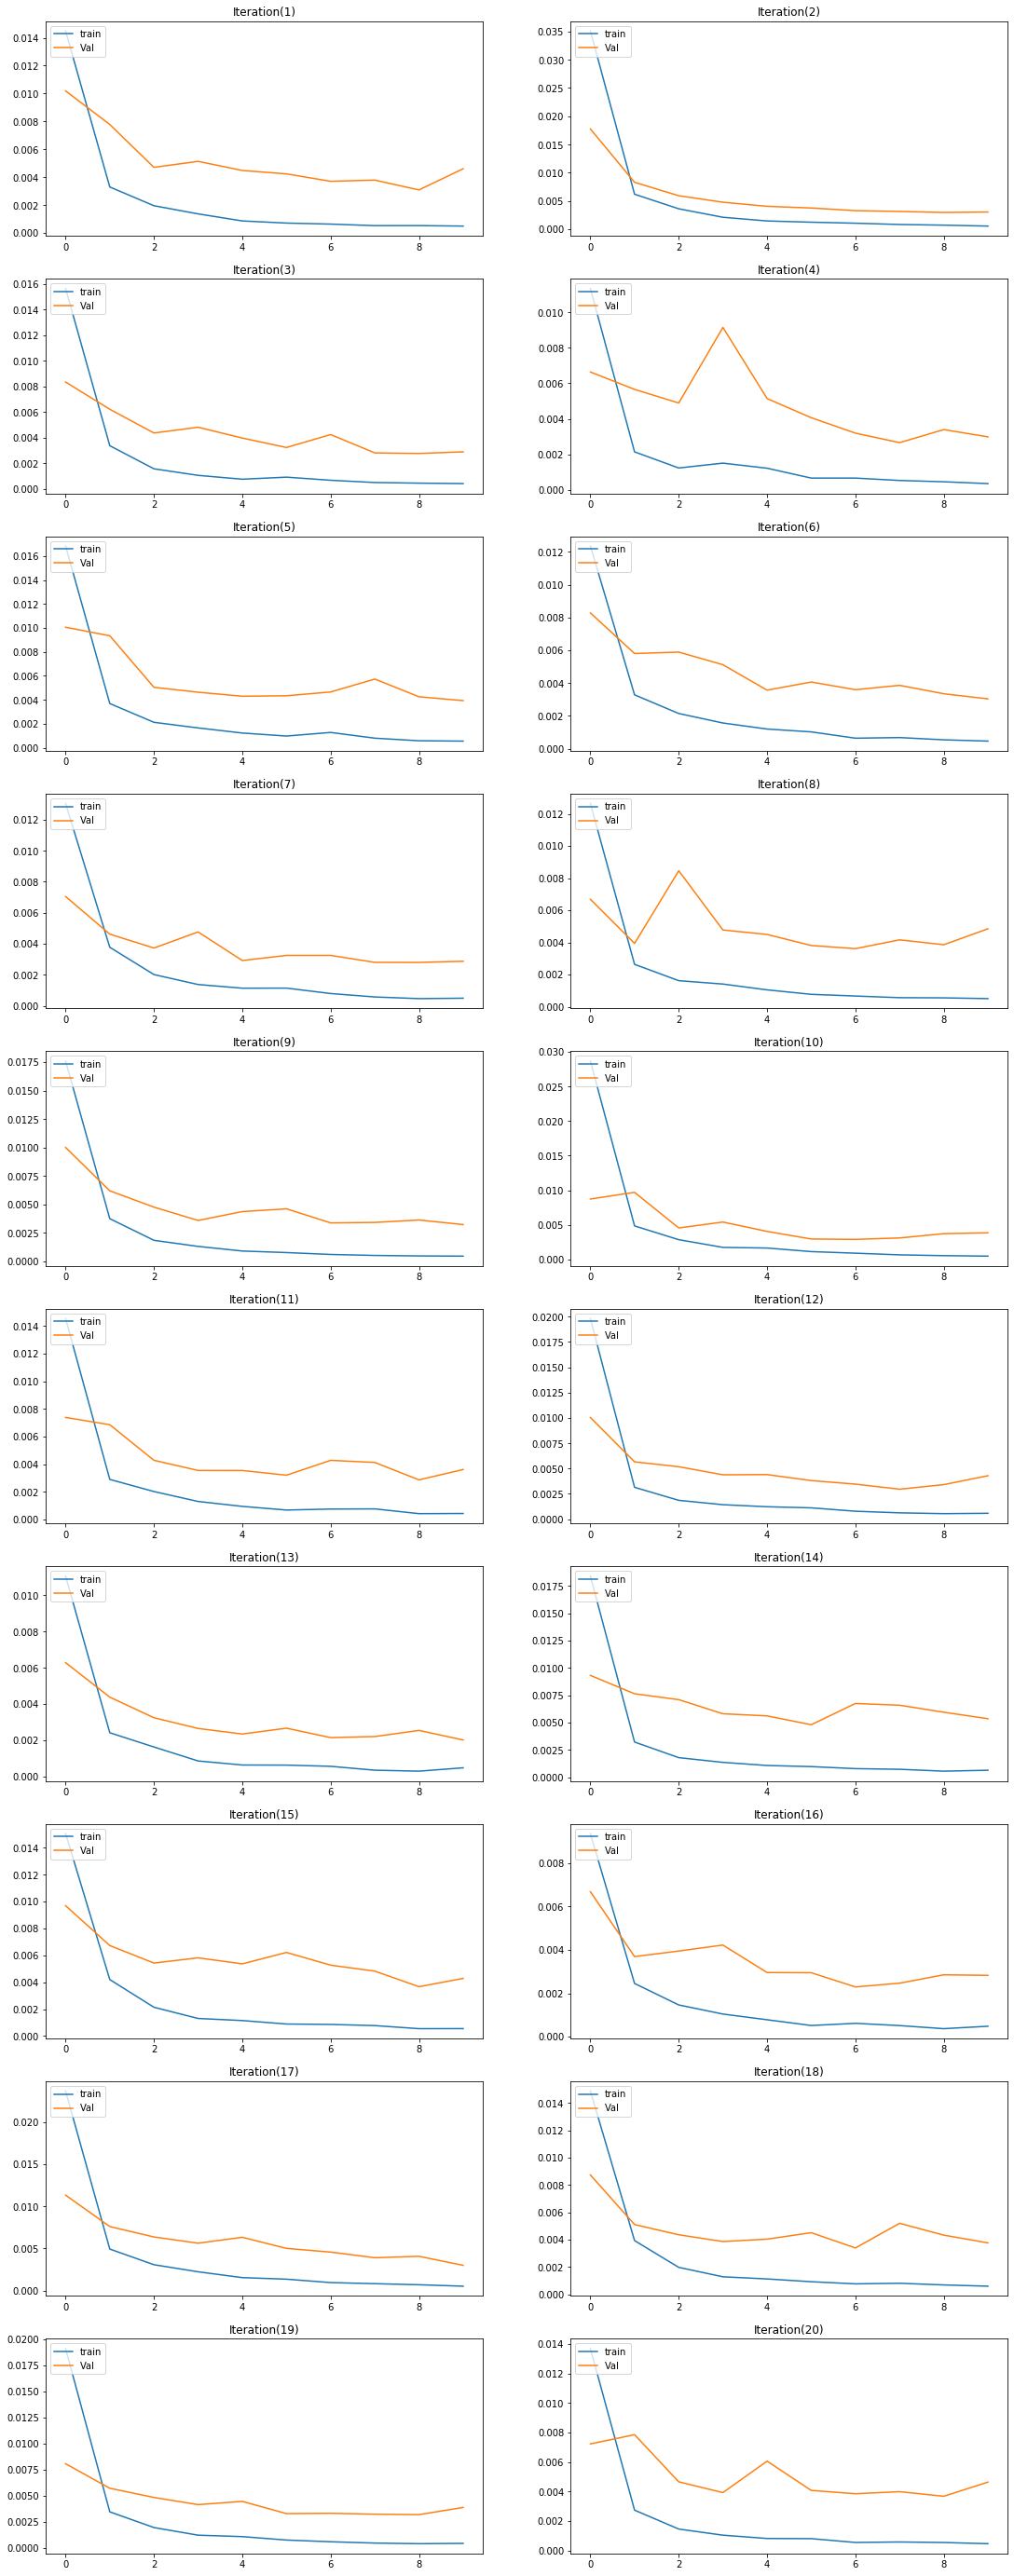

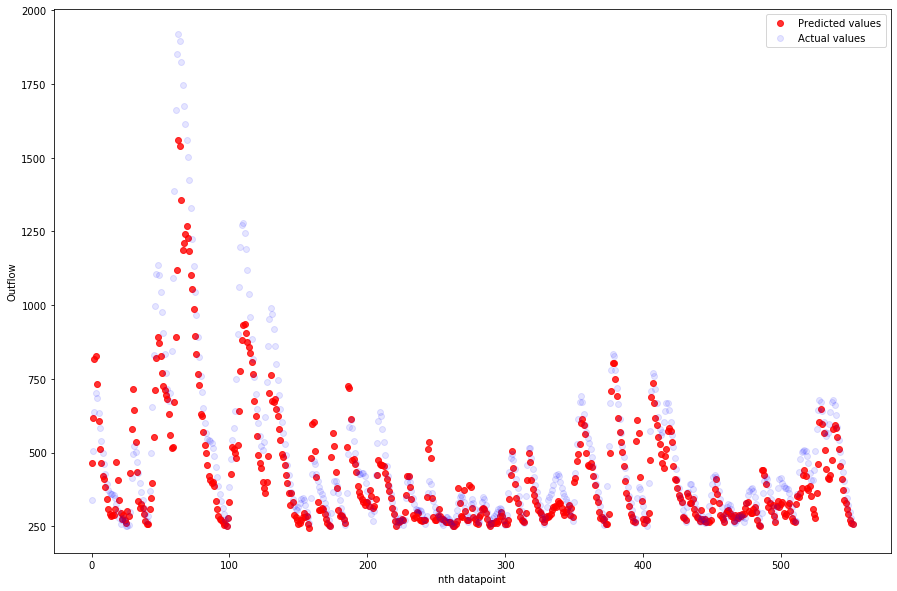

In [15]:
def plot_evaluation():
    #mean square error over iterations
    plt.figure(figsize=(15, 10))
    plt.plot(mse_for_iter)
    plt.ylabel('mean squared error')
    plt.xlabel('iteration')
    plt.savefig('mse.png', bbox_inches='tight')
    plt.show()
        
    #plot train and validation loss over epochs for each iteration
    fig, axs = plt.subplots(10, 2)
    #axs.set_ylabel('loss')
    #axs.set_xlabel('epoch')
    fig.set_size_inches(18.5, 50)
    for row in range(10):
        for col in range(2):
            index = 2*row + col #index to get loss from training loss and validation loss list
            axs[row, col].plot(train_loss_over_epoch[index])
            axs[row, col].plot(val_loss_over_epoch[index])
            axs[row, col].set_title('Iteration(%d)' %(index+1))
            axs[row, col].legend(['train', 'Val'], loc='upper left')            
    plt.savefig('train_val_loss.png', bbox_inches='tight')
    
    #plot predicted value vs actual values from last iteration
    plt.figure(figsize=(15, 10))
    plt.plot(predicted_y_values_unnor, 'ro', alpha=0.8)
    plt.plot(Y_test_abv_thres, 'bo', alpha=0.1)
    plt.legend(['Predicted values', 'Actual values'], loc='upper right')
    plt.ylabel('Outflow')
    plt.xlabel('nth datapoint')
    plt.savefig('predicted_values_visuals.png', bbox_inches='tight')
    plt.show()
    
#call plot_evaluation function
plot_evaluation()

In [16]:
mse_for_iter

[215464.69995881963,
 233604.7939368898,
 239363.75744262672,
 242675.441490479,
 240914.4795929368,
 254829.95359100684,
 234356.64244835512,
 211666.939969344,
 238264.0836136803,
 214808.59639083105,
 248228.4888142105,
 234637.6875571732,
 245496.24308047415,
 225027.54465471022,
 271872.98546433845,
 231594.27294341975,
 260494.95572334583,
 259535.98935365854,
 229759.01269860702,
 214547.86637046273]

In [17]:
print(np.mean(mse_for_iter))

237357.22175476846


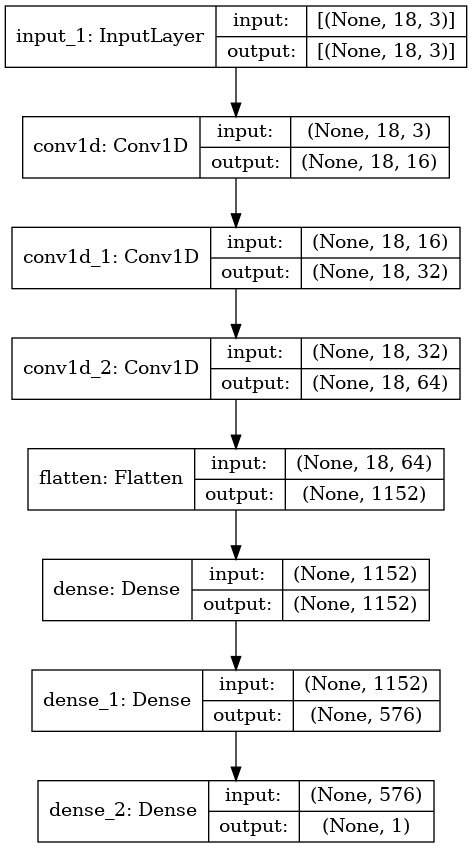

In [18]:
plot_model(model, show_shapes=True)

In [19]:
# building timeseries data with given timesteps
def timeseries(X, Y, Y_actual, time_steps, out_steps):
    input_size_0 = X.shape[0] - time_steps
    input_size_1 = X.shape[1]
    output_size_0 = Y.shape[0] - time_steps
    output_size_1 = Y.shape[1]
    X_values = np.zeros((input_size_0, time_steps, input_size_1))
    Y_values = np.zeros((output_size_0, output_size_1))
    Y_values_actual = np.zeros((output_size_0, output_size_1))
    
    for i in tqdm_notebook(range(input_size_0)):
        X_values[i] = X[i:time_steps+i]
        Y_values[i] = Y[time_steps+i-1]
        Y_values_actual[i] = Y_actual[time_steps+i-1]
        
    print("length of time-series i/o",X_values.shape,Y_values.shape)
    return X_values, Y_values, Y_values_actual

#getting data ready for training the model
def data_processing(lag_df):   
    #Normalizing training data
    x_train_nor = xtrain_min_max_scaler.fit_transform(x_train)
    y_train_nor = ytrain_min_max_scaler.fit_transform(y_train)

    # Normalizing test data
    x_test_nor = xtest_min_max_scaler.fit_transform(x_test)
    y_test_nor = ytest_min_max_scaler.fit_transform(y_test)
    
    # Saving actual train and test y_label
    y_train_actual = y_train
    y_test_actual = y_test
    
    return x_train_nor, y_train_nor, y_train_actual, x_test_nor, y_test_nor, y_test_actual

In [21]:
#Building timeseries
x_train_nor, y_train_nor, y_train_actual, x_test_nor, y_test_nor, y_test_actual = data_processing(lag_df)
X_Train, Y_Train, Y_train_actual = timeseries(x_train_nor, y_train_nor, y_train_actual, time_steps=18, out_steps=1)
X_Test, Y_Test, Y_test_actual = timeseries(x_test_nor, y_test_nor, y_test_actual, time_steps=18, out_steps=1)

/home/bidur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()



length of time-series i/o (148416, 18, 3) (148416, 1)



length of time-series i/o (37091, 18, 3) (37091, 1)


In [22]:
y_train_predict = model.predict(X_Train)

In [23]:
Y_Train_predict = ytrain_min_max_scaler.inverse_transform(y_train_predict)

In [24]:
mean_squared_error(Y_Train_predict, Y_train_actual)

6798.20375230718

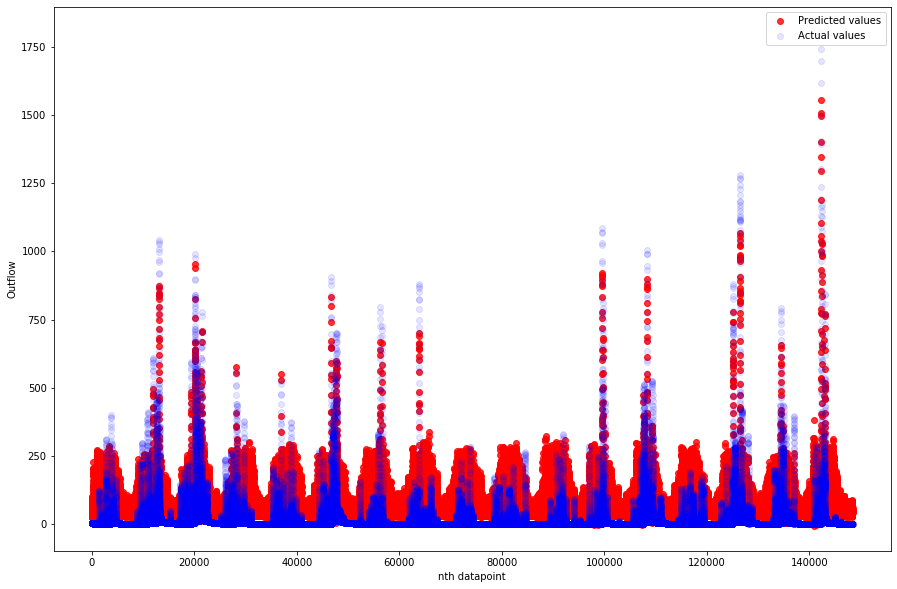

In [25]:
#plot predicted value vs actual values from last iteration
plt.figure(figsize=(15, 10))
plt.plot(Y_Train_predict, 'ro', alpha=0.8)
plt.plot(Y_train_actual, 'bo', alpha=0.1)
plt.legend(['Predicted values', 'Actual values'], loc='upper right')
plt.ylabel('Outflow')
plt.xlabel('nth datapoint')
plt.savefig('predicted_values_visuals.png', bbox_inches='tight')
plt.show()